<a href="https://colab.research.google.com/github/nepslor/teaching/blob/main/2021SmartGrids/L03_TimeSeriesForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# L03: Introduction to power forecasting
In this lesson we will go through basic concepts of time-series analysis, visualization and power forecasting techniques. 
Let's start from downloading a dataset containing power measurements and meteorological forecasts relative to a set of 24 power meters located in Rolle (Switzerland). We start importing and installing required packages

In [ ]:
%%capture
!pip install wget
!pip install statsmodels==0.12.2
import pandas as pd
import wget
import numpy as np

The dataframe contains a set of power series from different meters and the most updated forecasts of the global horizontal irradiance (GHI) and the temperature (T), povided by a numerical weather prediction service. Let's print some rows...

In [ ]:
data = pd.read_pickle(wget.download("https://zenodo.org/record/4549296/files/reduced_dataset.pk?download=1"));
data.head()

0307a3cec15787560b7d0ba094f74d1decb2fa72  ...                                        temperature
2018-01-13 00:10:00+00:00                                  9.786000  ...  [3.6288461538461543, 3.589157030333501, 3.4878...
2018-01-13 00:20:00+00:00                                 11.190000  ...  [3.6256410256410265, 3.5733366851013924, 3.477...
2018-01-13 00:30:00+00:00                                 10.712333  ...  [3.620769230769231, 3.554524886877828, 3.46849...
2018-01-13 00:40:00+00:00                                 12.445000  ...  [3.6146153846153846, 3.53470755823697, 3.45838...
2018-01-13 00:50:00+00:00                                 10.487000  ...  [3.6075641025641025, 3.515870621752975, 3.4460...

[5 rows x 33 columns]

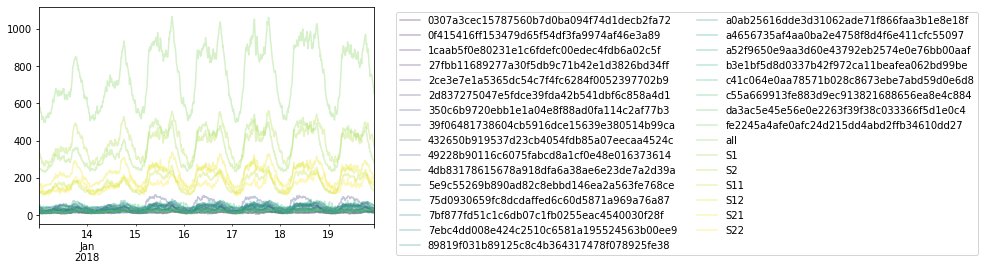

In [ ]:

import matplotlib.pyplot as plt
plot_these = [n for n in data.columns if n not in ["ghi_backwards", "temperature"]]
data[plot_these].iloc[:1000,:].plot(alpha=0.3, cmap=plt.get_cmap('viridis'));
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2) 

The data pd.DataFrame contains power signals from 24 secondary substations, and a list of their aggregations (S11,S12..) and the overall sum (all). We will focus on the prediction of the total aggregated power, so we discard the rest. For sake of simplicity, we will also downsample the dataframe to 1 hour sampling time. This is just a practical choice to avoid to use excessive computational power and ease the visualization of the different variables; it doesn't impact any following consideration.  

In [ ]:
samples_per_day = 24
p_all = data['all'].resample('1h', origin='start').mean()
data = pd.concat([p_all,data['ghi_backwards'].iloc[::6], data['temperature'].iloc[::6]], axis=1)
data.head()

all  ...                                        temperature
2018-01-13 00:10:00+00:00  569.445444  ...  [3.6288461538461543, 3.589157030333501, 3.4878...
2018-01-13 01:10:00+00:00  528.453278  ...  [3.589157030333501, 3.4878365352875162, 3.4057...
2018-01-13 02:10:00+00:00  507.449722  ...  [3.4878365352875162, 3.405724059468352, 3.1049...
2018-01-13 03:10:00+00:00  525.023444  ...  [3.405724059468352, 3.1049134528586584, 2.6353...
2018-01-13 04:10:00+00:00  534.641833  ...  [3.1049134528586584, 2.635389610389611, 2.4121...

[5 rows x 3 columns]

# Time series visualization
Sometimes, time series data can have seasonalities. If seasonalities are present, we can use them as an embedding for the time series; this can help compressing (and thus predicting) the signal. 

A simple and effective way to find seasonalities is to use the autocorrelation function:
$$a(x, k)=\frac{1}{\sigma_x^{2}} \frac{1}{T-k} \sum_{t=1}^{T-k}\left(x_{t}-\mu_{x}\right)\left(x_{t+k}-\mu_{x}\right)$$

Let's try to rewrite the autocorrelation function in python, using lambda functions:

In [ ]:
autocorr = lambda x, k: k # FILL THIS FUNCTION with your version of the autocorrelation function
corrs = [autocorr(data['all'].values, k) for k in range(100)]
plt.plot(corrs)

Pandas already implements an autocorrelation function. We use it to compare the autocorrelation of the 'all' signal with the one of other kinds of time series.

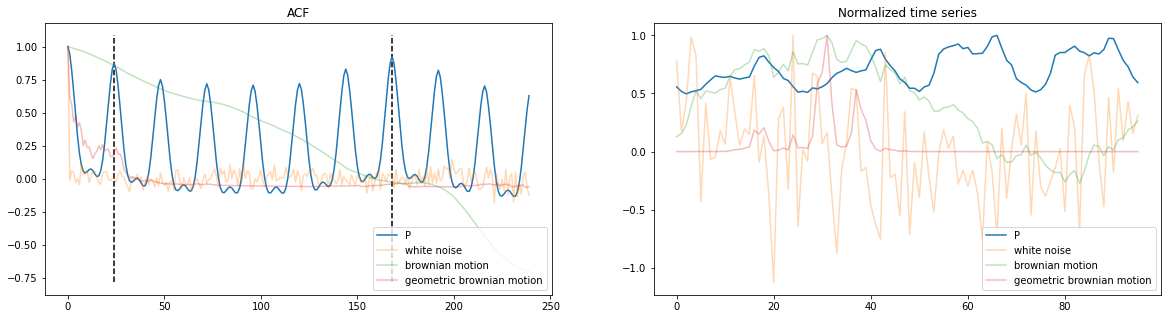

In [ ]:
np.random.seed(0)
max_lag = samples_per_day * 10

# generate white noise, brownian motion and geometric brownian motion
white_noise = np.random.randn(max_lag*2)
brownian_motion = np.cumsum(white_noise)
geometric_brownian_motion = np.cumprod(np.exp(white_noise))


# Plotting ACF for the four signals
fig, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].plot([data['all'].autocorr(i) for i in range(max_lag)], label='P')
ax[0].plot([pd.Series(white_noise).autocorr(i) for i in range(max_lag)], label='white noise', alpha=0.3)
ax[0].plot([pd.Series(brownian_motion).autocorr(i) for i in range(max_lag)], label='brownian motion', alpha=0.3)
ax[0].plot([pd.Series(geometric_brownian_motion).autocorr(i) for i in range(max_lag)], label='geometric brownian motion', alpha=0.3)
ylims = ax[0].get_ylim(); ax[0].vlines(samples_per_day, *ylims, linestyles='--'); ax[0].vlines(samples_per_day*7, *ylims, linestyles='--')
ax[0].legend(loc="lower right")
ax[0].set_title('ACF')

# Plotting the associated time series
ax[1].plot(data['all'].iloc[:samples_per_day*4].values/data['all'].iloc[:samples_per_day*4].max(), label='P')
ax[1].plot(white_noise[:samples_per_day*4]/np.max(white_noise[:samples_per_day*4]), label='white noise', alpha=0.3)
ax[1].plot(brownian_motion[:samples_per_day*4]/np.max(brownian_motion[:samples_per_day*4]), label='brownian motion', alpha=0.3)
ax[1].plot(geometric_brownian_motion[:samples_per_day*4]/np.max(geometric_brownian_motion[:samples_per_day*4]), label='geometric brownian motion', alpha=0.3)
ax[1].legend(loc="lower right");
ax[1].set_title('Normalized time series');


Strong seasonalities can be spotted at 24 hours intervals, with a second local maximum after 7 days (the second dashed vertical line), indicating a strong weekly seasonality. As a comparison, the orange and the green lines represent the autocorrelations of white noise (iid samples from a noraml distribution) and of brownian motion. 

We can now try to use the two local maxima as embedding for the time series, and try to see if the signal can be compressed. We start by using 24 steps as embedding dimension (corresponding to the first maximum of the auto correlation function) and plot the resulting matrix as a picture. 

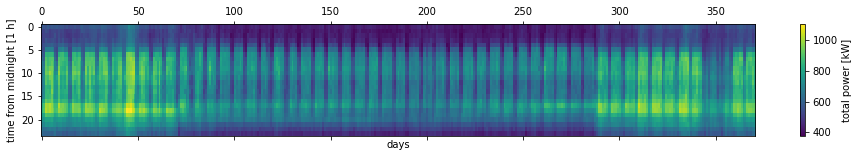

In [ ]:

l = len(data['all'])
n_max = int(l/(samples_per_day*7))*samples_per_day*7
d_mat = data['all'].values[:n_max].reshape(-1, samples_per_day).T
weeks_mat = data['all'].values[:n_max].reshape(-1, samples_per_day*7).T

plt.matshow(d_mat, aspect='auto')
plt.xlabel('days')
plt.ylabel('time from midnight [1 h]')
plt.colorbar(label='total power [kW]');

The above picture can be interpreted as following: the columns of the above matrix represent days, while its rows correspond to different times of a given day. We can observe how daily peaks (lighter pixels) usually occurs at the same time of the day. At the same time we observe the daylight saving shift, meaning that the timestamp of the data is in UTC. This means that if we want to use the hour of the day as an explanatory variable we should transform the timestamp in localtime first. Now let's try to plot the same data as time series, using both one day and one week as embedding, to see if we can gain more insight. 

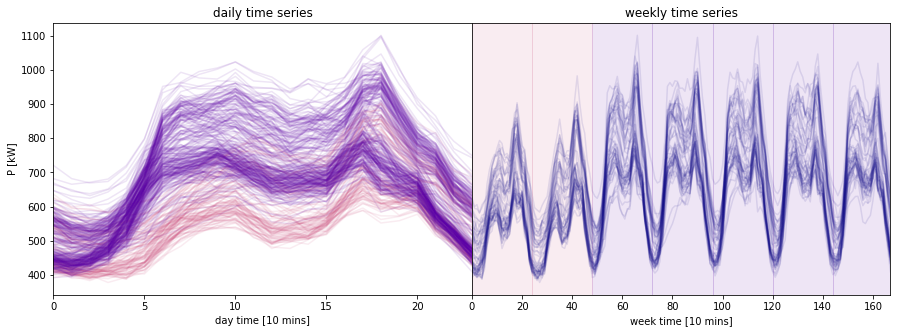

In [ ]:
colors = plt.get_cmap('plasma',7)
fig, ax = plt.subplots(1,2, figsize=(15,5))
plt.subplots_adjust(wspace=0)
[ax[0].plot(d_mat[:, i::7], c=colors(1 if i>1 else 3), alpha=0.1) for i in range(7)];
ax[0].set_xlim(0,samples_per_day-1)
ax[0].set_xlabel('day time [10 mins]')
ax[0].set_ylabel('P [kW]')
ax[0].set_title('daily time series')


ax[1].plot(weeks_mat, alpha=0.1, color=colors(0));
[ax[1].axvspan(samples_per_day*i, samples_per_day*(i+1), alpha=0.1, color=colors(1 if i>1 else 3)) for i in range(7)];
ax[1].set_xlim(0,samples_per_day*7-1)
ax[1].set_yticks([]);
ax[1].set_xlabel('week time [10 mins]');
ax[1].set_title('weekly time series');


In the above picture the data embedding dimension is 24 and 168, for the right and left panels, respectively. We can see how daily data is highly self-similar, but two clusters can be distinguished: weekdays and weekends. The same can be observed looking at the 7 days embedding (left), where the red vertical bands corresponds to weekends. This kind of visualization guides us in the choice of the forecasting model: we can already see how a simple AR model will probably perform poorly if we do not include 168 autoregressive steps. More on this later on. Let's now visualize interactions between the variable, its lag at -1 day, and the meteorological variables in the dataset. We resample the data to 1 hour sampling time to avoid eccessive computational time in the visualization.

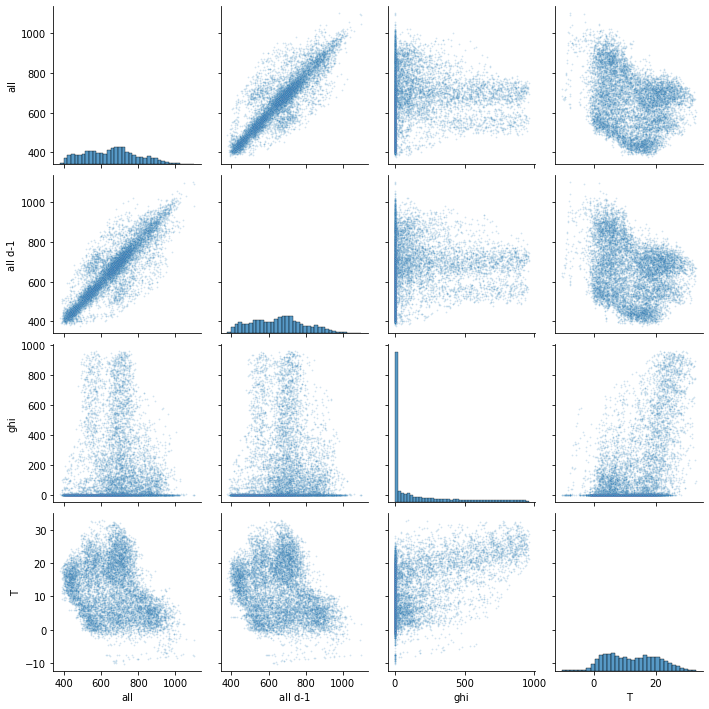

In [ ]:
import seaborn as sb
all_1d_delay = np.roll(data[['all']].values, shift=samples_per_day)[samples_per_day:]                              # np.roll shifts the array by "shift" steps 
ghi = np.vstack(data['ghi_backwards'])[samples_per_day:,[0]]
temperature = np.vstack(data['temperature'])[samples_per_day:,[0]]
plot_data = pd.DataFrame(np.hstack([data[['all']].values[samples_per_day:],all_1d_delay, 
                                    ghi, temperature]), columns
                         =['all', 'all d-1','ghi', 'T'], index=data.index[samples_per_day:])
sb.pairplot(plot_data,plot_kws={"s": 3, "alpha":0.2})


We can see how the power at current time is highly correlated with its daily lag, as we expected to see from the ACF plot. We can observe also a slightly negative correlation with the temperature predicted by the NWP service for the next hour. This can indicate the presence of electric-based heating, like heat pumps. On the other hand, we cannot spot an evident correlation with the solar irradiation, which means no relevant amount of PVs power plants are installed in this grid. 

# Training and testing

Usually, we are not interested in retrieving a model which predicts the data we have with the highest accuracy, but rather in fitting a model with good performance on unseen data, or, using machine learning jargon, which can "generalize" well.
 


# AR, ARX, ARMA and ARIMA models
These models, among with [Holt-Winters](https://otexts.com/fpp2/expsmooth.html) models (a.k.a. exponential smoothing) and the [Kalman filter](https://en.wikipedia.org/wiki/Kalman_filter), are usually interpreted as graphical probabilistic models. Once the models' parameters have been estimated, the forecast is obtained recursively applying the model and updating the engogenous input history with the newly produced forecast.

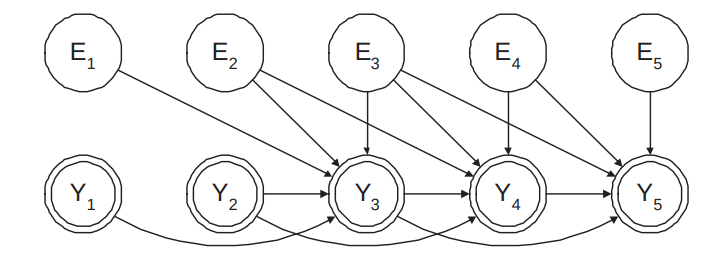   
*Graphial representation of and ARMA model, from Thiesson, B. et al. “ARMA Time-Series Modeling with Graphical Models.” UAI (2004).*

We recall that the generic ARIMA model can be written as: 
$$ \Theta(l)^p (1-l)^d y_t = \Phi(l)^q \epsilon $$
where p,d,q are the order of the model for the autoregressive, differences, and moving average components and l is the delay operator, $l(y_t) = y_{t-1}$. Here $\epsilon$ is a Gaussian noise.

Among the classical time series models, AR and ARX models are the easiest to fit, since they do not need to estimate the residual error at fitting time, and its parameters can be thus extimated one shot using linear regression, for example.
We will follow this simple strategy.
We recall that ARX models can be written as:
$$y_{t} = Y_t\theta_y + X_t\theta_x + \epsilon_t$$
where $Y_t = [y_{t-k}]_{k\in[1,2..p]} \in \mathbb{R}^{t \times p}$ is the matrix whose columns are k-lags of the target, $X_t \in \mathbb{R}^{t \times v}$ is a matrix of exogenous inputs and $\theta_y \in \mathbb{R}^p, \theta_x \in \mathbb{R}^v$ are the unknown vectors of parameters representing the influence of the columns of $Y_t$ and $X_t$ over $y_t$ that we want to estimate. Here $\epsilon_t \sim \mathcal{N}(0,\sigma)$ is the noise term, which we model as iid samples from a Gaussian distribution. Under this assumption, the parameters can be estimated via linear regression:
$$ \theta^* = argmin_{\theta} \Vert y - D \theta \Vert_2^2 + R(\theta)$$
where $D=[Y,X]$ is the design matrix, $\theta = [\theta_y^T, \theta_x^T]^T$ and $R$ is a regularizer which can be used to find a stable dynamic model. We will use $R(\theta) =\lambda \Vert  \theta\Vert_2^2$ as regularizer, also known as L2 or Ridge regularization, which is a special case of [Tikhonov](https://en.wikipedia.org/wiki/Tikhonov_regularization) regularization. 

In the folloing cell a basic arx_model class is defined, with a $\lambda$ parameter for the Ridge penalization and pre-normalization of the inputs.  We define also some auxiliary functions: add_lags(lags) for augmenting the dataset with backward or forward lags of its variables, and tr_te_split(data) for splitting the data in training and testing sets. The latter will be useful later to compare the generalization performance of some of the models we will train. 

In [ ]:
def add_lags(data, lags, name='all'):
  "adds lagged version of the signal with a given name to the data in the \
  DataFrame. Positive lags: shift forward (future), negative lags: shift\
  backward (past)."
  lagged_signal = pd.concat([data.copy()[[name]].shift(-l) for l in lags], axis=1)
  lagged_signal.columns=['{}_lag_{}'.format(name, l) for l in lags]
  lagged_dat = pd.concat([data, lagged_signal], axis=1)
  return lagged_dat.loc[~np.any(lagged_dat.isna(), axis=1)]

def tr_te_split(data, split_ratio=0.75):
  "divides data into training and test sets "
  n_tr = int(len(data)*split_ratio)
  return data.iloc[:n_tr, :], data.iloc[n_tr:, :]


class arx_model:
  "A simple arx model. Fit is done minimizing squared error of the one step \
  ahead forecasts"
  def __init__(self, lambda_lr):
    self.lambda_lr = lambda_lr
    self.theta = None
    self.mean = None
    self.std = None

  def fit(self, y, Y, X=None):
    # normalize the signal
    self.mean = y.mean()
    self.std = y.std()
    y = (y-self.mean)/self.std
    Y = (Y-self.mean)/self.std

    # define the design matrix D
    D = Y.values.reshape((len(Y),-1)) if X is None else np.hstack([Y.values] + [np.vstack(X[c])[:,[0]] for c in X.columns])
    self.theta = np.linalg.inv(D.T@D + self.lambda_lr*np.eye(D.shape[1]))@(D.T@y.values)
    return self
  
  def forecast(self, Y, X=None, steps_ahead=1):
    y_hat = np.zeros((len(Y), steps_ahead))
    Y = (Y.values -self.mean)/self.std 

    for s in range(steps_ahead):
      D = Y if X is None else np.hstack([Y] + [np.vstack(X[c])[:,[s]] for c in X.columns])
      y_hat[:,s] = D @ self.theta
      Y = np.hstack([y_hat[:,[s]], Y[:, 1:]])   # dynamic update of the history
    return y_hat * self.std+ self.mean

from matplotlib import animation
from IPython.display import HTML

def ts_animation(y_te, y_hat, n_rows=50):
  "plot the first n_rows of the two y_te and y_hat matrices"
  fig, ax = plt.subplots(1);

  line1, = ax.plot(y_hat[0], lw=2);
  line2, = ax.plot(y_hat[0], lw=2);
  ax.set_ylim(200, 900)
  
  def animate(i):
    line1.set_data(np.arange(24),y_te.values[i:i+24]);
    line2.set_data(np.arange(24),y_hat[i,:]);
    return (line1,line2) 


  def init():
    line1.set_data([], []);
    return (line1,)

  ani = animation.FuncAnimation(fig, animate, init_func=init, frames=n_rows, interval=100, 
                                save_count=50,blit=True)
  plt.close('all')
  #rc('animation', html='jshtml')
  return HTML(ani.to_jshtml())

We can now try to train a order one AR model and an order one ARX model. We chose the value of lambda performing a grid search on the training set and looking at the 1 step-ahead forecast error in terms of root mean squared error (RMSE). 

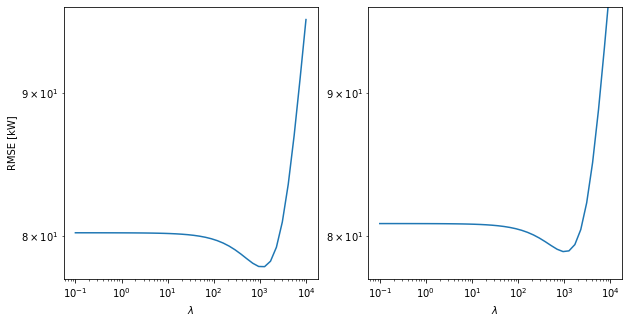

In [ ]:
rmse = lambda err: np.mean(err**2)**0.5


data_tr, data_te = tr_te_split(add_lags(data, -np.arange(1,2), name='all'))
Y_tr, Y_te = data_tr[[n for n in data_tr.columns if 'all_lag' in n]], data_te[[n for n in data_te.columns if 'all_lag' in n]]
X_tr, X_te = data_tr[[n for n in data_tr.columns if 'all' not in n]], data_te[[n for n in data_te.columns if 'all' not in n]]
y_tr, y_te_ar = data_tr['all'], data_te['all']

# Train an ARX model with 1 autoregressive step
lambdas = np.logspace(-1,4,40)
errs = [rmse(arx_model(l).fit(y_tr, Y_tr, X_tr).forecast(Y_tr, X_tr,  steps_ahead=1)[:-1, 0]-y_tr.values[1:]) for l in lambdas]   # for all the lambdas, fit, forecast and compute the 1 step-ahead RMSE   
best_lambda = lambdas[np.argmin(errs)]
arx = arx_model(best_lambda).fit(y_tr, Y_tr, X_tr)
y_hat_arx = arx.forecast(Y_te, X_te,  steps_ahead=24)

# Train an AR model with 1 autoregressive step
errs_ex = [rmse(arx_model(l).fit(y_tr, Y_tr).forecast(Y_tr,  steps_ahead=1)[:-1, 0]-y_tr.values[1:]) for l in lambdas]
best_lambda = lambdas[np.argmin(errs_ex)]
ar = arx_model(best_lambda).fit(y_tr, Y_tr)
y_hat_ar = ar.forecast(Y_te,  steps_ahead=24)

# plot RMSE as a function of the smoothing parameter
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(lambdas, errs)
ax[0].loglog()
ax[0].set_xlabel('$\lambda$')
ax[0].set_ylabel('RMSE [kW]')
ax[1].plot(lambdas, errs_ex)
ax[1].loglog()
ax[1].set_ylim(ax[0].get_ylim())
ax[1].set_xlabel('$\lambda$');


In [ ]:
# plot 50 steps of forecasts for the AR model
ts_animation(y_te_ar, y_hat_ar)

In [ ]:
# plot 50 steps of forecasts for the ARX model
ts_animation(y_te_ar, y_hat_arx)

More advanced methods exhist for fitting AR, ARMA and ARIMA processes. The [statsmodel](https://www.statsmodels.org/stable/index.html) package contains a collection of several time series models. Here we will focuse on the ARIMA class, which can be used to estimate any subclass of the SARIMAX family. Fitting an ARIMA instance returns an [ARIMAResults](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.html#statsmodels.tsa.arima.model.ARIMAResults) object, whose extend method can be used to update the model history and forecast beyond the data used to fit the model.  
In the following cell we see how to use this method to fit an ARIMA with p,q,d order (1, 0, 0) and ([1,24], 1, 1), respectively.

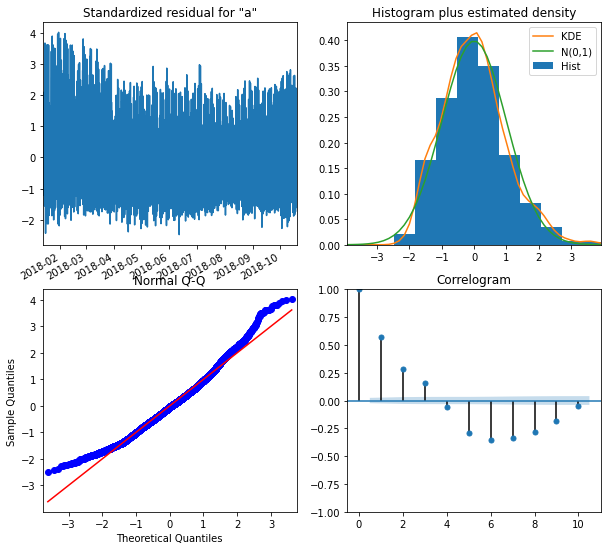

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
res = ARIMA(y_tr, order=([1], 0, 0)).fit()
res.plot_diagnostics(figsize=(10,10));

The plot_diagnostics method help us to get some insight on the fitting quality of the model. The first two plots represent the time series and the distributon of the one step-ahead prediction error; in the secon row we find the Q-Q plot,  which indicates discrepancies between the prediction quanile assuming a gaussian distributed residual and the actual sampled errors, and the ACF plot error. In this case we see how the error is highly correlated with itself. We can try to remove this effect by increasing the p and q order of the model. But first, let's forecast 100 steps continuously through the extend method, using the same model. 

In [ ]:
def get_forecasts(res, y_te, n_step_ahead=24, x_te=None):
  y_hat = np.zeros((len(y_te), n_step_ahead)) 
  for i in tqdm(range(len(y_te))):
    y_hat[i,:] = res.forecast(n_step_ahead)
    res = res.extend(y_te.iloc[[i]])
  return y_hat
y_hat = get_forecasts(res, y_te_ar.iloc[:100], 24)
ts_animation(y_te_ar, y_hat)

100%|██████████| 100/100 [00:01<00:00, 63.15it/s]


The model doesn't seem to perform particularly better than the previously fitted custom AR and ARX models. Let's try to increase the order of the p and q parts to obtain better predictions for the whole 24 hours horizon.

In [ ]:
res = ARIMA(y_tr, order=([1,24], 0, 1)).fit()
y_hat = get_forecasts(res, y_te_ar.iloc[:100], 24)
res.plot_diagnostics(figsize=(10,10));
ts_animation(y_te_ar, y_hat)

100%|██████████| 100/100 [00:01<00:00, 50.61it/s]


# Stateless models
So far we have seen how we can train classic econometrics models which typically forecast new data applying a recursive strategy. Now we will have a look at regression models which directly map an historical dataset $Y \in \mathbb{R}^{t\times p}$ to the whole forecasting horizon, ancoded in the matrix $y \in \mathbb{R}^{t\times f}$ where $p$ and $f$ are the number of past timesteps in the history and the number of steps in the forecasting horizon. If additional exogenous variables are available, they can be used to augment the historical values and form the design matrix $D=[Y,X]$, as we have previously seen for the ARX model.  
Given these matrices, the forecasting task can be interpreted as a regression task, in which we want to learn the parameters of a generic regressor $f(\theta)$, such that 
$$\theta^* = argmin_{\theta} \Vert f(D, \theta) - y\Vert_2^2 $$
We first see how to build these matrices in the next cell, and then we will try to fit the following regression models:
* a multivariate linear regression model
* a multivariate kNN model
* a set of boosted trees regressors

====================================================================================================  Future target y  ====================================================================================================
|                           |   all_lag_1 |   all_lag_2 |   all_lag_3 |   all_lag_4 |   all_lag_5 |   all_lag_6 |   all_lag_7 |   all_lag_8 |   all_lag_9 |   all_lag_10 |   all_lag_11 |   all_lag_12 |   all_lag_13 |   all_lag_14 |   all_lag_15 |   all_lag_16 |   all_lag_17 |   all_lag_18 |   all_lag_19 |   all_lag_20 |   all_lag_21 |   all_lag_22 |   all_lag_23 |   all_lag_24 |
|:--------------------------|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|-------------:|-------------:|-------------:|-------------:|-------------:|-------------:|-------------:|-------------:|-------------:|-------------:|-------------:|-------------:|-------------:|-------------:|-------------:|
| 2018-01-20 00:10

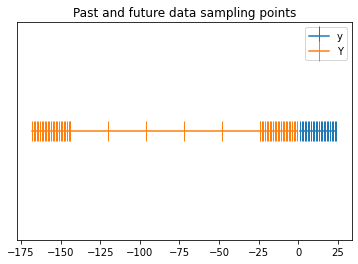

In [ ]:
future_steps = np.arange(1,25)
past_steps = -np.hstack([np.arange(1,25),np.arange(1,7)*24, np.arange(168-24,169)])
data_tr, data_te = tr_te_split(add_lags(data, (future_steps).tolist() + (past_steps).tolist(), name='all'))
y_tr, y_te_reg = data_tr[[n for n in data_tr.columns if 'all_lag' in n and '-' not in n]], data_te[[n for n in data_te.columns if 'all_lag' in n  and '-' not in n]]
Y_tr, Y_te = data_tr[[n for n in data_tr.columns if '-' in n]], data_te[[n for n in data_te.columns if '-' in n]]
X_tr, X_te = data_tr[[n for n in data_tr.columns if 'all' not in n]], data_te[[n for n in data_te.columns if 'all' not in n]]
V_tr = np.hstack([Y_tr.values, np.hstack([np.vstack(X_tr[c]) for c in X_tr.columns])])
V_te = np.hstack([Y_te.values, np.hstack([np.vstack(X_te[c]) for c in X_te.columns])])

print('='*100 + '  Future target y  ' + '='*100)
print(y_tr.head().to_markdown())
print('='*100 + '  Past target Y  ' + '='*100)
print(Y_tr.head().to_markdown())
print('='*100 + '  NWP forecasts  ' + '='*100)
print(X_tr.head(2).to_markdown())

plt.plot(future_steps, np.ones_like(future_steps), marker='|', markersize=20, label='y')
plt.plot(past_steps, np.ones_like(past_steps), marker='|', markersize=20, label='Y')
plt.yticks([])
plt.legend()
plt.title('Past and future data sampling points');

In the following cell we'll define a linear model with Ridge penalization, an offset, and with input normalization, as we have previously done for the custom ARX model.

In [ ]:
class lin_model:
  def __init__(self, lambda_lr):
    self.mean_y = None
    self.std_y = None
    self.mean_d = None
    self.std_d = None
    self.theta_lr = None
    self.lambda_lr = lambda_lr
    
  def fit(self, y, D):
    self.mean_y = np.mean(y, axis=0)
    self.std_y = np.std(y, axis=0)
    self.mean_d = np.mean(D, axis=0)
    self.std_d = np.std(D, axis=0)
    y = (y -self.mean_y)/self.std_y  
    D = np.hstack([np.ones((len(D),1)), (D-self.mean_d)/self.std_d])

    self.theta_lr = np.linalg.inv(np.hstack([D.T@D + self.lambda_lr*np.eye(D.shape[1])])) @ (D.T@y)
    return self

  def predict(self, D):
    D = (D-self.mean_d)/self.std_d
    y_hat = (np.hstack([np.ones((len(D),1)), D])@self.theta_lr) * self.std_y + self.mean_y
    return y_hat 

# search for the optimal lamda minimizing the RMSE for the whole horizon
lambdas = np.logspace(-2,2,10)
rmses = [rmse(y_tr.values.ravel()-lin_model(l).fit(y_tr.values, V_tr).predict(V_tr).ravel()) for l in lambdas]
lambda_opt = lambdas[np.argmin(rmses)]

# fit and predict with the optimal lambda
y_hat_lin = lin_model(lambda_opt).fit(y_tr.values, V_tr).predict(V_te)

ts_animation(y_te_reg.iloc[:, 0], y_hat_lin)

The results are very good, considering the simplicity of the method and the very low training and inference time compared to the previous implementations of the ARIMAX family. Finally, we consider the univariate boosted trees implemented in the [lightGBM](https://lightgbm.readthedocs.io/en/latest/) library. The  models are tought to predict only one target at the time, that is, are multiple input single output models (MISO). We can use a set of MISO models to predict the whole forecasting horizon: each model will be trained on the target at different steps-ahead, so that the final model can be written as:
$$f(D, \theta) = [f_i(D_i,\theta)]_{i\in[1...h]}$$
For sake of simplicity, we will keep the same $D_i=D$ for all the models.
The following line of code does the trick.

In [ ]:
from lightgbm import LGBMRegressor
gb_models = [LGBMRegressor(n_estimators=100, lr=0.01).fit(V_tr,y_tr.values[:,i]) for i in range(y_tr.shape[1])]

In [ ]:
y_hat_lgb= np.hstack([m.predict(V_te).reshape(-1,1) for m in gb_models])
ts_animation(y_te_reg.iloc[:, 0], y_hat_lgb)

# Performace analysis and model selection
Model selection is the process of chosing a forecasting model based on its estimated generalization performaces. Several methods can be used, among which information-based criterion as the [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion) and [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion). These make use of the likelihood function associated with a given model, that is the probability of observing the data under given model parameters $\theta$ and statistical assumptions about the distribution of the error. A widely used technique to assess the generalization error is to divide the dataset in a training and testing set $\mathcal{D}_{tr}, \mathcal{D}_{te}$, train the model using only data from $\mathcal{D}_{tr}$ and test its performance on $\mathcal{D}_{te}$. We already followed this strategy, using the tr_te_split function. We will now compare the results for the linear model and the lightGBM model, for which we already have the whole prediction on the test set. 

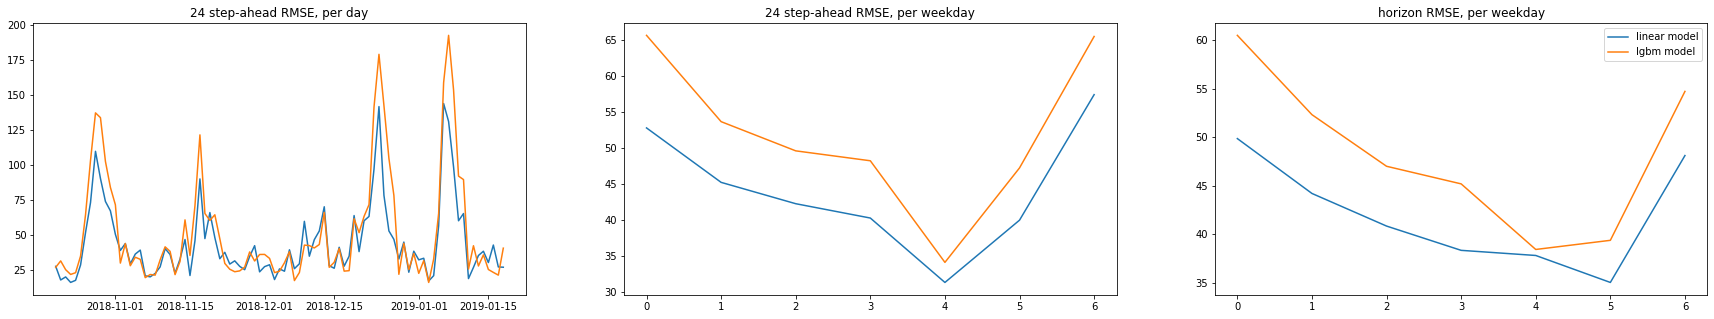

In [ ]:
def get_rmse(y_hat, y_te, steps=None):
  if steps is None:
    steps = [0]
  sqerr = pd.DataFrame((y_te.values-y_hat)**2, index=y_te.index)
  daily_rmse_step = sqerr[steps].resample('1d').mean()**0.5
  weekly_rmse_step = daily_rmse_step.groupby(daily_rmse_step.index.weekday).mean()
  hourly_rmse_horizon = (sqerr.mean(axis=1)**0.5).groupby(sqerr.index.hour).mean()
  daily_rmse_horizon = (sqerr.mean(axis=1)**0.5).groupby(sqerr.index.weekday).mean()
  return daily_rmse_step,weekly_rmse_step, daily_rmse_horizon

daily_step_lin, weekly_step_lin, daily_horizon_lin = get_rmse(y_hat_lin, y_te_reg, steps=[23])
daily_step_lgb, weekly_step_lgb, daily_horizon_lgb = get_rmse(y_hat_lgb, y_te_reg, steps=[23])


fig, ax = plt.subplots(1,3, figsize=(30,5))

ax[0].plot(daily_step_lin)
ax[0].plot(daily_step_lgb)
ax[0].set_title('24 step-ahead RMSE, per day')
ax[1].plot(weekly_step_lin)
ax[1].plot(weekly_step_lgb)
ax[1].set_title('24 step-ahead RMSE, per weekday')
ax[2].plot(daily_horizon_lin, label='linear model')
ax[2].plot(daily_horizon_lgb, label='lgbm model')
ax[2].set_title('horizon RMSE, per weekday');
plt.legend()

The two models present very simlar error patterns. In particular, they seem to struggle in predicting the signal for given days of the week. We can try to improve the LightGBM model adding categorical features, like the day of the week and hour of the day. We can additional use target encoding, a technique that replace labels of categorical features with the average of the target for a given label's value.

In [ ]:
%%capture
!pip install category_encoders
import category_encoders as ce
cat_features = ['wd','dh']
V_tr_cat = pd.DataFrame(np.hstack([V_tr, y_tr.index.weekday.values.reshape(-1,1), y_tr.index.hour.values.reshape(-1,1)]), columns=[i for i in range(V_tr.shape[1])] + cat_features)
V_te_cat = pd.DataFrame(np.hstack([V_te, y_te_reg.index.weekday.values.reshape(-1,1), y_te_reg.index.hour.values.reshape(-1,1)]), columns=[i for i in range(V_te.shape[1])] + cat_features)
y_hat_lgb = []
for i in range(y_tr.shape[1]):
  target_enc = ce.CatBoostEncoder(cols=cat_features)
  target_enc.fit(V_tr_cat[cat_features], y_tr.values[:,i])
  df_train = V_tr_cat.join(target_enc.transform(V_tr_cat[cat_features]).add_suffix('_cb'))
  df_test = V_te_cat.join(target_enc.transform(V_te_cat[cat_features]).add_suffix('_cb'))
  lgb_model = LGBMRegressor(n_estimators=100, lr=0.01).fit(df_train,y_tr.values[:,i])
  y_hat_lgb.append(lgb_model.predict(df_test).reshape(-1,1))
y_hat_lgb = np.hstack(y_hat_lgb)

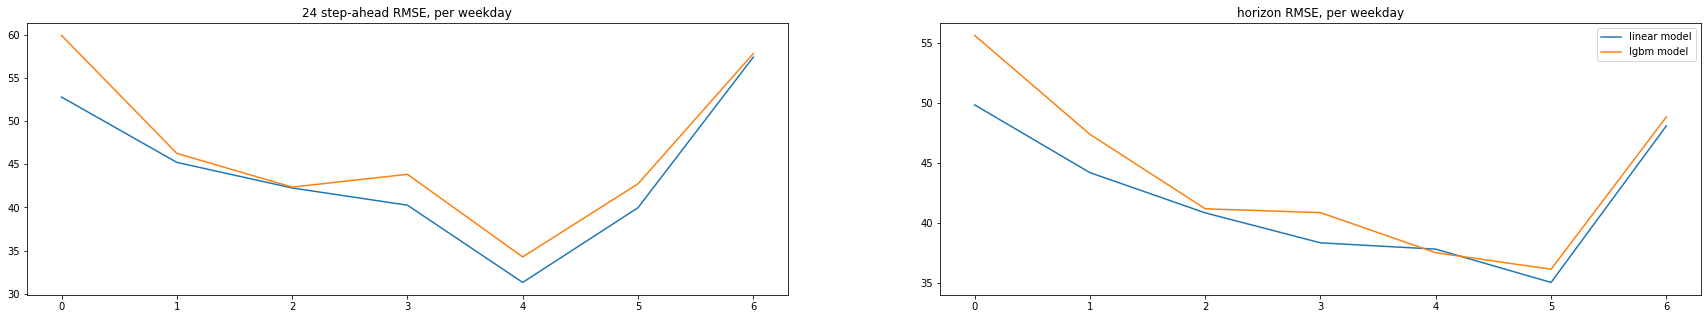

<Figure size 2160x360 with 0 Axes>

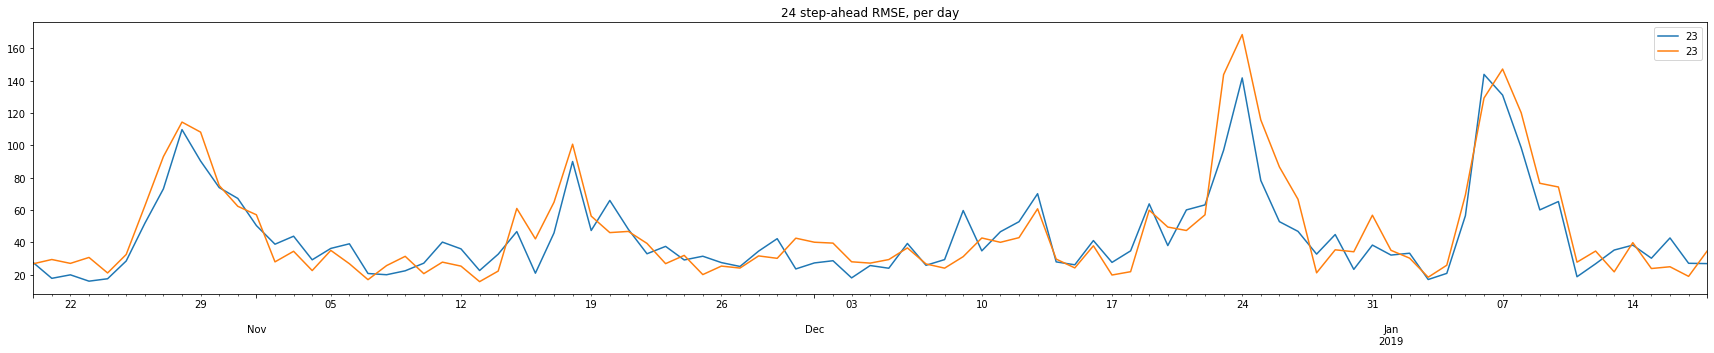

In [ ]:
daily_step_lin, weekly_step_lin, daily_horizon_lin = get_rmse(y_hat_lin, y_te_reg, steps=[23])
daily_step_lgb, weekly_step_lgb, daily_horizon_lgb = get_rmse(y_hat_lgb, y_te_reg, steps=[23])


fig, ax = plt.subplots(1,2, figsize=(30,5))
ax[0].plot(weekly_step_lin)
ax[0].plot(weekly_step_lgb)
ax[0].set_title('24 step-ahead RMSE, per weekday')
ax[1].plot(daily_horizon_lin, label='linear model')
ax[1].plot(daily_horizon_lgb, label='lgbm model')
ax[1].set_title('horizon RMSE, per weekday');
plt.legend()

plt.figure(figsize=(30,5))
pd.concat([daily_step_lin,daily_step_lgb],axis=1).plot(figsize=(30,5))
plt.title('24 step-ahead RMSE, per day');


# Exercise 
Besides the increse of performance, the LightGBM model performances are not better than the simple linear model. Looking at the daily error patterns, can you think of some handcrafted (categorical or continuous) feature you can pass to LightGBM to improve its RMSE and beat the linear model?